# Practical Exercise (Optional): Create Modern Modular Network 

In this exercise, you are going to make use of some architecural elements that you learnt, such as residual connection, and separable convolution, and combine them into a building block, and use this building block to construct a modular network. 

This building block is similar to what [Xception](https://arxiv.org/abs/1610.02357) is using. 

Here is the simplified view of our network: 

![xception](https://nyp-aicourse.s3.ap-southeast-1.amazonaws.com/it3103/resources/mini_xception.png)

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

**Exercise 1**

Let us the define our xception block first. Here are the steps you will need to do: 
1. First save the output from previous block (or if this is the first block, then output from previous convolutional/maxpooling layer) and use this as skip connection to be added later
2. Add the 2 separable convolutional and the maxpool layer. 
3. Add BatchNormalization after each separable convolutional layer (as practiced by modern architecture).  You can add BatchNormalization before or after Activation layer.
4. Use 1x1 conv to change the depth of the skip connection to match that of the rest of layers and add the skip connection to the output from MaxPooling layer. You will also need to reduce the size to match the output from MaxPooling layer, by using a stride size of 2
5. As recommended by author of ResNet, the skip connection should be added before the Activation function. 

In [2]:
def xception_block(x, depth): 
    """
    Parameters:
    -----------
    x: output from the previous block or previous layer, considered as input to this Xception block
       it is a tensor of shape (batch, h, w, channels)
    depth: number of channels, it is an int value
    """
    
    # save input to be used as skip connection
    skip_connection = x
    
    # add the first separable convolutional 2D layer
    x = layers.SeparableConv2D(depth, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    # add the second separable convolutional 2D layer, without the activation layer
    x = layers.SeparableConv2D(depth, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    
    # add the maxpooling 2d layer, with stride of 2
    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
    
    # adjust the size and depth using 1x1 convolution to match the output from last maxpooling layer
    residual = layers.Conv2D(depth, 1, strides=2, padding="same")(
        skip_connection
    )
    
    # add the skip connection 
    x = layers.add([x, residual])  # Add back residual
    
    # add the activation layer
    x = layers.Activation("relu")(x)
    
    return x # Set aside next residual

**Exercise 2:**

We will then build our complete network using the xception block defined in the previous exercise: 
1. Define the input layer with appropriate shape
2. Define a rescaling layer to normalize the input to (0,1)
3. Define the entry blocks that consist of 2 convolutional 2D layers 
4. Add the series of xception blocks, with different depths `[128,256,512,728]`
5. Add the last Separable convolutional 2D layer 
6. Add GlobalAveragePooling2D layer before connected to output Dense Layer
7. Use Dropout for the dense layer 



In [3]:
def make_model(input_shape, num_classes): 
    inputs = keras.Input(shape=input_shape)
    
    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    # build a series of xception blocks with different sizes
    for size in [128, 256, 512, 728]:
        # Code here
        x = xception_block(x, size)
    
    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

2021-10-21 14:13:39.258349: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-10-21 14:13:39.328473: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-10-21 14:13:39.329736: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-10-21 14:13:39.331431: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

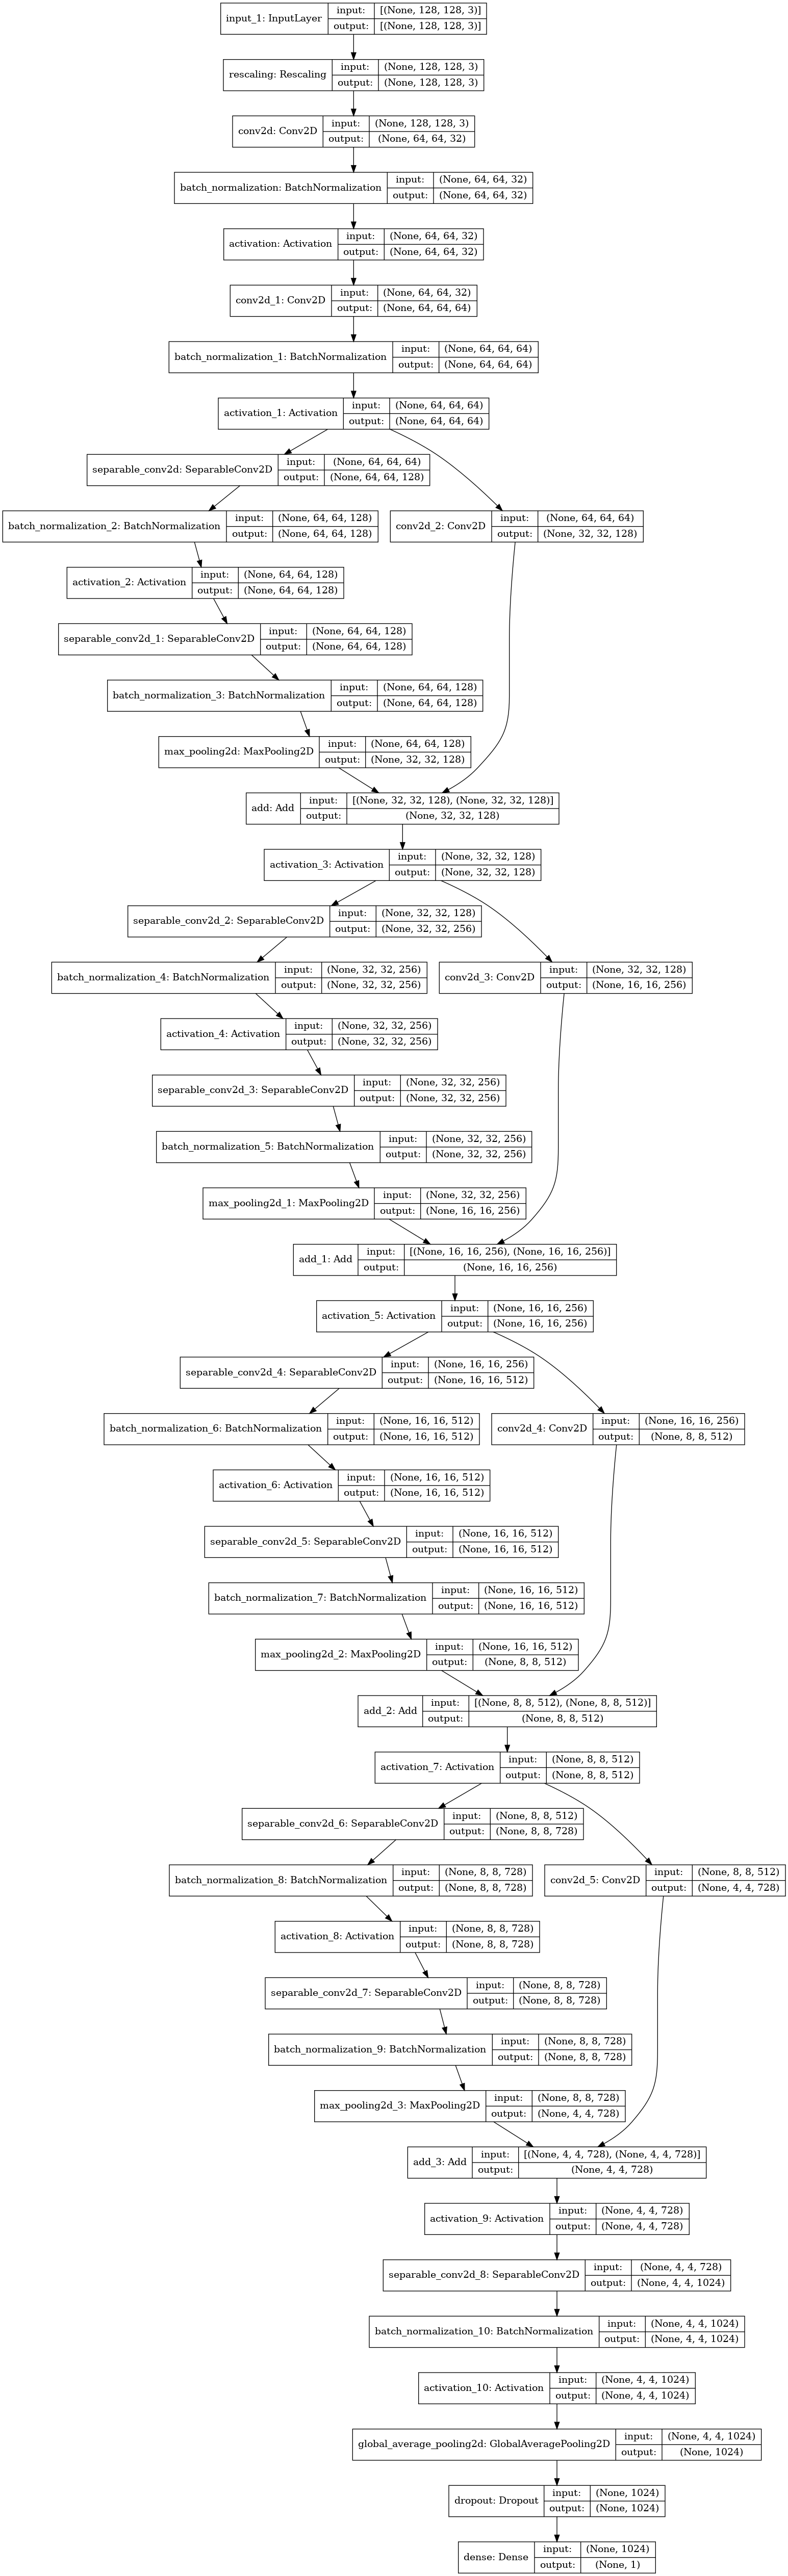

In [4]:
image_size = (128,128)

model = make_model(input_shape= image_size + (3,), num_classes=2)

keras.utils.plot_model(model, show_shapes=True)

### Create train and validation dataset

We will go ahead and download the same dataset, and setup the training and validation dataset.

In [5]:
import os 

dataset_URL = 'https://nyp-aicourse.s3-ap-southeast-1.amazonaws.com/datasets/cats_and_dogs_subset.tar.gz'
tf.keras.utils.get_file(origin=dataset_URL, extract=True, cache_dir='.')
dataset_folder = os.path.join('datasets', 'cats_and_dogs_subset')

In [6]:
batch_size = 8

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_folder,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='binary'
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_folder,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='binary'
)

Found 3000 files belonging to 2 classes.
Using 2400 files for training.
Found 3000 files belonging to 2 classes.
Using 600 files for validation.


Ok, everything is ready. Now we are ready to put our mini-xception network to test and see if perform better than our previous 'traditional' CNN architecture. 

In [7]:
def create_tb_callback(): 

    import os
    
    root_logdir = os.path.join(os.curdir, "tb_logs")

    def get_run_logdir():    # use a new directory for each run
        
        import time
        
        run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
        return os.path.join(root_logdir, run_id)

    run_logdir = get_run_logdir()

    tb_callback = tf.keras.callbacks.TensorBoard(run_logdir)

    return tb_callback

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="bestcheckpoint",
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


# compile our model with loss and optimizer 
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)


model.fit(
    train_ds, epochs=30, 
    validation_data=val_ds,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/30


2021-10-21 14:13:44.197217: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-10-21 14:13:45.139901: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8200


300/300 [==============================] - 21s 48ms/step - loss: 0.7039 - accuracy: 0.5858 - val_loss: 0.7472 - val_accuracy: 0.4867
Epoch 2/30
300/300 [==============================] - 16s 54ms/step - loss: 0.6419 - accuracy: 0.6446 - val_loss: 0.6977 - val_accuracy: 0.6033
Epoch 3/30
300/300 [==============================] - 16s 54ms/step - loss: 0.5931 - accuracy: 0.7063 - val_loss: 0.6684 - val_accuracy: 0.6383
Epoch 4/30
300/300 [==============================] - 16s 53ms/step - loss: 0.5569 - accuracy: 0.7163 - val_loss: 0.7872 - val_accuracy: 0.6533
Epoch 5/30
300/300 [==============================] - 17s 56ms/step - loss: 0.5210 - accuracy: 0.7462 - val_loss: 0.9974 - val_accuracy: 0.5617
Epoch 6/30
300/300 [==============================] - 17s 58ms/step - loss: 0.4952 - accuracy: 0.7688 - val_loss: 0.5999 - val_accuracy: 0.6850
Epoch 7/30
300/300 [==============================] - 16s 53ms/step - loss: 0.4427 - accuracy: 0.7992 - val_loss: 1.7732 - val_accuracy: 0.5533
Epo

In [9]:
best_checkpoint = 'bestcheckpoint'

model.load_weights(best_checkpoint)
model.evaluate(val_ds)

 1/75 [..............................] - ETA: 3s - loss: 0.9339 - accuracy: 0.7500

2021-10-21 14:23:35.140248: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open bestcheckpoint: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


75/75 [==============================] - 1s 11ms/step - loss: 0.6393 - accuracy: 0.7950


[0.6393044590950012, 0.7950000166893005]